In [1]:
cd /home

/home


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# Sampling random windows

In [4]:
def sample_lc(sequence, max_obs):
    '''
    Sample a random window of "max_obs" observations from the input sequence
    '''
    serie_len = tf.shape(sequence)[0]

    pivot = 0
    if tf.greater(serie_len, max_obs):
        pivot = tf.random.uniform([],
                                  minval=0,
                                  maxval=serie_len-max_obs+1,
                                  dtype=tf.int32)

        sequence = tf.slice(sequence, [pivot,0], [max_obs, -1])
    else:
        sequence = tf.slice(sequence, [0,0], [serie_len, -1])

    return sequence

In [5]:
times = tf.range(0, 15, dtype=tf.float32)
magnitudes = tf.sin(times)
sequence = tf.transpose(tf.stack([times, magnitudes], 0))

2021-11-14 17:53:59.980087: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: UNKNOWN ERROR (34)
2021-11-14 17:53:59.980181: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (153b5d94f976): /proc/driver/nvidia/version does not exist
2021-11-14 17:53:59.980675: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


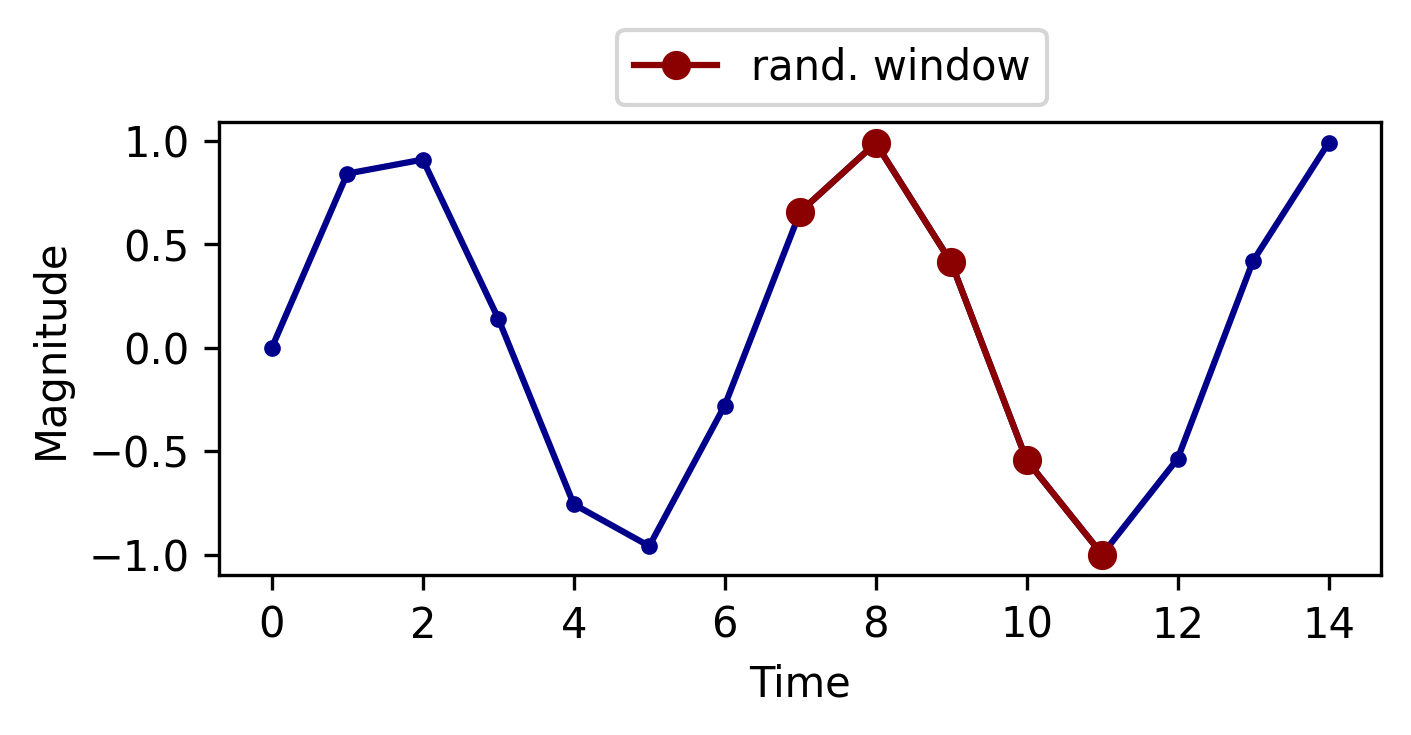

In [6]:
for i in range(20):
    plt.figure(figsize=(5,2), dpi=300)
    plt.plot(sequence[:, 0], sequence[:, 1], marker='.', color='darkblue')
    sample = sample_lc(sequence, max_obs=5)
    plt.plot(sample[:, 0], sample[:, 1], marker='o', color='darkred', label='rand. window')
    plt.xlabel('Time')
    plt.ylabel('Magnitude')
    plt.legend(bbox_to_anchor=(.73, 1.25))
#     plt.savefig('./presentation/figures/sampling/{}.png'.format(i), bbox_inches='tight', dpi=300)
    break

# Moving window

In [4]:
cd /home/users/cdonoso/astromer/ASTROMER/

/home/users/cdonoso/astromer/ASTROMER


In [5]:
import tensorflow as tf 

from core.data import pretraining_records

%load_ext autoreload
%autoreload 2

In [19]:
batches = pretraining_records('./data/records/alcock/train', 
                             16, 
                             shuffle=False, 
                             sampling=False,
                             max_obs=200,
                             msk_frac=0, 
                             rnd_frac=0, 
                             same_frac=0)

2021-11-14 17:56:35.292302: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


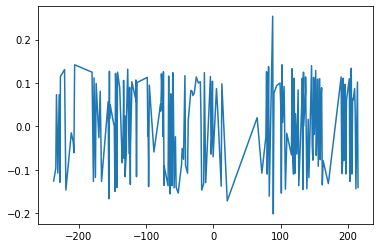

In [21]:
for batch in batches:
    plt.plot(batch['times'][0][...,0], batch['input'][0][...,0])
    break

#  create fold using saved att. vectors

In [8]:
cd ../..

/home/users/cdonoso/astromer/ASTROMER


In [3]:
import h5py
import numpy as np
import os

In [10]:
def load_embeddings(source):
    file = open(source, 'rb')
    hf = h5py.File(file)
    att = hf['att'][()]
    x = hf['x'][()]
    t = hf['t'][()]
    y = hf['y'][()]
    m = hf['m'][()]
    return att, y, m, x, t

In [11]:
source = './embeddings/alcock/'
target = './encoded/alcock'

In [23]:
att_train, y_train, m_train, x_train, t_train = load_embeddings(os.path.join(source, 'train.h5'))
att_val, y_val, m_val, x_val, t_val = load_embeddings(os.path.join(source, 'val.h5'))
att_test, y_test, m_test, x_test, t_test = load_embeddings(os.path.join(source, 'test.h5'))

print(att_train.shape)
print(att_val.shape)
print(att_test.shape)

(47107, 200, 256)
(23369, 200, 256)
(7855, 200, 256)


# Training from saved model

In [4]:
cd /home/users/cdonoso/astromer/ASTROMER/

/home/users/cdonoso/astromer/ASTROMER


In [5]:
import tensorflow as tf 
import numpy as np
import pandas as pd
import os

os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [6]:
metadata = pd.read_csv('./data/raw_data/alcock/alcock_dataset.dat')

unique_classes = list(metadata['Class'].unique())
unique_classes

['LPV', 'Cep_0', 'RRab', 'RRc', 'EC', 'UNK', 'Cep_1']

In [7]:
lightcurves = []
labels = []
for k, row in metadata.iterrows():
    
    lc = pd.read_csv('./data/raw_data/alcock/LCs/{}.dat'.format(row['ID']))
    lc = lc.sort_values('mjd')
    if lc.shape[0] >=100:
        lightcurves.append(lc.values[:100])
        labels.append(unique_classes.index(row['Class']))
    

In [8]:
from sklearn.model_selection import train_test_split

In [60]:
X = np.array(lightcurves)
y = np.array(lightcurves)[...,1]

X = (X-np.min(X, 1)[:,None,:])/(np.max(X,1)[:,None,:]-np.min(X, 1)[:,None,:])
y = (y-np.min(y, 1)[:, None])/(np.max(y, 1)[:, None]-np.min(y, 1)[:, None])

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [62]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

In [63]:
def get_encoder():
    inputs = Input(shape=(100, 3))
    x = LSTM(256, return_sequences=True)(inputs)
    x = LSTM(256, name='encoder')(x)
    x = tf.tile(tf.expand_dims(x, 1), [1, 100, 1])
    x = tf.concat([tf.expand_dims(inputs[...,0],2), x], 2)
    x = LSTM(256, return_sequences=True)(x)
    x = LSTM(256, return_sequences=True)(x)
    x = Dense(1)(x)
    return Model(inputs=inputs, outputs=x, name="Model")

In [64]:
model = get_encoder()
model.summary()

Model: "Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 100, 3)]     0                                            
__________________________________________________________________________________________________
lstm_11 (LSTM)                  (None, 100, 256)     266240      input_5[0][0]                    
__________________________________________________________________________________________________
encoder (LSTM)                  (None, 256)          525312      lstm_11[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_3 (Sli (None, 100)          0           input_5[0][0]                    
______________________________________________________________________________________________

In [65]:
model.compile(
    loss='mean_absolute_error',
    optimizer='adam',
    metrics=["mean_absolute_error"],
)

In [66]:
estop = EarlyStopping(monitor='val_loss',
                      min_delta=0,
                      patience=40,
                      verbose=0,
                      mode='auto',
                      baseline=None,
                      restore_best_weights=True)

In [69]:
history = model.fit(X_train, y_train, batch_size=256, epochs=1000, callbacks=[estop], validation_split=0.2)

Epoch 1/1000
50/50 [==============================] - 5s 50ms/step - loss: 0.1928 - mean_absolute_error: 0.1928 - val_loss: 0.1699 - val_mean_absolute_error: 0.1699
Epoch 2/1000
50/50 [==============================] - 2s 33ms/step - loss: 0.1647 - mean_absolute_error: 0.1647 - val_loss: 0.1619 - val_mean_absolute_error: 0.1619
Epoch 3/1000
50/50 [==============================] - 2s 34ms/step - loss: 0.1643 - mean_absolute_error: 0.1643 - val_loss: 0.1636 - val_mean_absolute_error: 0.1636
Epoch 4/1000
50/50 [==============================] - 2s 34ms/step - loss: 0.1616 - mean_absolute_error: 0.1616 - val_loss: 0.1613 - val_mean_absolute_error: 0.1613
Epoch 5/1000
50/50 [==============================] - 2s 34ms/step - loss: 0.1602 - mean_absolute_error: 0.1602 - val_loss: 0.1594 - val_mean_absolute_error: 0.1594
Epoch 6/1000
50/50 [==============================] - 2s 34ms/step - loss: 0.1624 - mean_absolute_error: 0.1624 - val_loss: 0.1607 - val_mean_absolute_error: 0.1607
Epoch 7/10

50/50 [==============================] - 2s 35ms/step - loss: 0.1266 - mean_absolute_error: 0.1266 - val_loss: 0.1288 - val_mean_absolute_error: 0.1288
Epoch 51/1000
50/50 [==============================] - 2s 34ms/step - loss: 0.1262 - mean_absolute_error: 0.1262 - val_loss: 0.1287 - val_mean_absolute_error: 0.1287
Epoch 52/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.1264 - mean_absolute_error: 0.1264 - val_loss: 0.1296 - val_mean_absolute_error: 0.1296
Epoch 53/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.1259 - mean_absolute_error: 0.1259 - val_loss: 0.1283 - val_mean_absolute_error: 0.1283
Epoch 54/1000
50/50 [==============================] - 2s 34ms/step - loss: 0.1259 - mean_absolute_error: 0.1259 - val_loss: 0.1287 - val_mean_absolute_error: 0.1287
Epoch 55/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.1259 - mean_absolute_error: 0.1259 - val_loss: 0.1284 - val_mean_absolute_error: 0.1284
Epoch 56/1000
50/5

50/50 [==============================] - 2s 35ms/step - loss: 0.1163 - mean_absolute_error: 0.1163 - val_loss: 0.1189 - val_mean_absolute_error: 0.1189
Epoch 100/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.1161 - mean_absolute_error: 0.1161 - val_loss: 0.1184 - val_mean_absolute_error: 0.1184
Epoch 101/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.1162 - mean_absolute_error: 0.1162 - val_loss: 0.1185 - val_mean_absolute_error: 0.1185
Epoch 102/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.1157 - mean_absolute_error: 0.1157 - val_loss: 0.1190 - val_mean_absolute_error: 0.1190
Epoch 103/1000
50/50 [==============================] - 2s 34ms/step - loss: 0.1157 - mean_absolute_error: 0.1157 - val_loss: 0.1181 - val_mean_absolute_error: 0.1181
Epoch 104/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.1154 - mean_absolute_error: 0.1154 - val_loss: 0.1186 - val_mean_absolute_error: 0.1186
Epoch 105/100

50/50 [==============================] - 2s 35ms/step - loss: 0.1061 - mean_absolute_error: 0.1061 - val_loss: 0.1086 - val_mean_absolute_error: 0.1086
Epoch 149/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.1052 - mean_absolute_error: 0.1052 - val_loss: 0.1100 - val_mean_absolute_error: 0.1100
Epoch 150/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.1059 - mean_absolute_error: 0.1059 - val_loss: 0.1099 - val_mean_absolute_error: 0.1099
Epoch 151/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.1052 - mean_absolute_error: 0.1052 - val_loss: 0.1092 - val_mean_absolute_error: 0.1092
Epoch 152/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.1051 - mean_absolute_error: 0.1051 - val_loss: 0.1080 - val_mean_absolute_error: 0.1080
Epoch 153/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.1049 - mean_absolute_error: 0.1049 - val_loss: 0.1075 - val_mean_absolute_error: 0.1075
Epoch 154/100

50/50 [==============================] - 2s 35ms/step - loss: 0.0985 - mean_absolute_error: 0.0985 - val_loss: 0.1030 - val_mean_absolute_error: 0.1030
Epoch 198/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.0978 - mean_absolute_error: 0.0978 - val_loss: 0.1035 - val_mean_absolute_error: 0.1035
Epoch 199/1000
50/50 [==============================] - 2s 34ms/step - loss: 0.0966 - mean_absolute_error: 0.0966 - val_loss: 0.1055 - val_mean_absolute_error: 0.1055
Epoch 200/1000
50/50 [==============================] - 2s 34ms/step - loss: 0.0970 - mean_absolute_error: 0.0970 - val_loss: 0.1025 - val_mean_absolute_error: 0.1025
Epoch 201/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.0964 - mean_absolute_error: 0.0964 - val_loss: 0.1064 - val_mean_absolute_error: 0.1064
Epoch 202/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.0976 - mean_absolute_error: 0.0976 - val_loss: 0.1029 - val_mean_absolute_error: 0.1029
Epoch 203/100

50/50 [==============================] - 2s 35ms/step - loss: 0.0896 - mean_absolute_error: 0.0896 - val_loss: 0.1036 - val_mean_absolute_error: 0.1036
Epoch 247/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.0903 - mean_absolute_error: 0.0903 - val_loss: 0.1006 - val_mean_absolute_error: 0.1006
Epoch 248/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.0933 - mean_absolute_error: 0.0933 - val_loss: 0.1072 - val_mean_absolute_error: 0.1072
Epoch 249/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.0964 - mean_absolute_error: 0.0964 - val_loss: 0.1016 - val_mean_absolute_error: 0.1016
Epoch 250/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.0898 - mean_absolute_error: 0.0898 - val_loss: 0.0998 - val_mean_absolute_error: 0.0998
Epoch 251/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.0895 - mean_absolute_error: 0.0895 - val_loss: 0.1023 - val_mean_absolute_error: 0.1023
Epoch 252/100

50/50 [==============================] - 2s 35ms/step - loss: 0.0839 - mean_absolute_error: 0.0839 - val_loss: 0.0995 - val_mean_absolute_error: 0.0995
Epoch 296/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.0835 - mean_absolute_error: 0.0835 - val_loss: 0.0993 - val_mean_absolute_error: 0.0993
Epoch 297/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.0877 - mean_absolute_error: 0.0877 - val_loss: 0.0996 - val_mean_absolute_error: 0.0996
Epoch 298/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.0831 - mean_absolute_error: 0.0831 - val_loss: 0.0989 - val_mean_absolute_error: 0.0989
Epoch 299/1000
50/50 [==============================] - 2s 34ms/step - loss: 0.0833 - mean_absolute_error: 0.0833 - val_loss: 0.0984 - val_mean_absolute_error: 0.0984
Epoch 300/1000
50/50 [==============================] - 2s 34ms/step - loss: 0.0826 - mean_absolute_error: 0.0826 - val_loss: 0.1001 - val_mean_absolute_error: 0.1001
Epoch 301/100

50/50 [==============================] - 2s 35ms/step - loss: 0.0810 - mean_absolute_error: 0.0810 - val_loss: 0.1001 - val_mean_absolute_error: 0.1001
Epoch 345/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.0781 - mean_absolute_error: 0.0781 - val_loss: 0.0991 - val_mean_absolute_error: 0.0991
Epoch 346/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.0775 - mean_absolute_error: 0.0775 - val_loss: 0.0999 - val_mean_absolute_error: 0.0999
Epoch 347/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.0779 - mean_absolute_error: 0.0779 - val_loss: 0.0992 - val_mean_absolute_error: 0.0992
Epoch 348/1000
50/50 [==============================] - 2s 34ms/step - loss: 0.0778 - mean_absolute_error: 0.0778 - val_loss: 0.0996 - val_mean_absolute_error: 0.0996
Epoch 349/1000
50/50 [==============================] - 2s 35ms/step - loss: 0.0791 - mean_absolute_error: 0.0791 - val_loss: 0.0998 - val_mean_absolute_error: 0.0998
Epoch 350/100

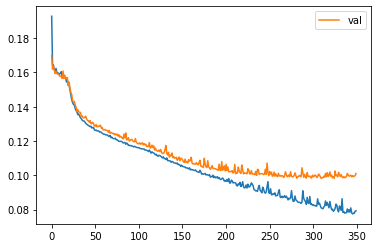

In [73]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], label='val')
plt.legend()

In [77]:
model.save('model.h5')

In [80]:
encoder = model.get_layer('encoder')
encoder.trainable = False

In [87]:
def get_dynamic(encoder):
    inputs = Input(shape=(100, 3))
    x = encoder(inputs)
#     x = Dense(512)(x)
#     x = Dense(256)(x)
#     x = Dense(1)(x)
    return Model(inputs=inputs, outputs=x, name="Model")

In [91]:
encoder.input

<KerasTensor: shape=(None, 100, 256) dtype=float32 (created by layer 'lstm_11')>

In [88]:
model = get_dynamic(encoder)
model.summary()

ValueError: Dimensions must be equal, but are 3 and 256 for '{{node MatMul}} = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false](strided_slice_1, kernel)' with input shapes: [?,3], [256,1024].